In [4]:
#importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests

In [5]:
#retrieving data from API

url = "https://services.nvd.nist.gov/rest/json/cves/2.0"

response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    df = pd.DataFrame(data['vulnerabilities'])
else:
    print(f"Failed to retrieve data: {response.status_code}")

inner_dicts = [v for d in data['vulnerabilities'] for v in d.values()]
df = pd.DataFrame(inner_dicts)


In [6]:
#cleaning the data

def extract_dict(entry, name):
    if isinstance(entry, list) and len(entry) > 0 and isinstance(entry[0], dict):
        original_dict = entry[0]
        # Rename keys by prefixing them with "name_"
        renamed_dict = {f"{name}_{k}": v for k, v in original_dict.items()}
        return renamed_dict
    return {}

def join_dict(DF, colname):
  DF[colname] = DF[colname].apply(lambda x: extract_dict(x, colname))
  sub_df = pd.json_normalize(DF[colname])
  return DF.drop(columns=colname).join(sub_df)

df = join_dict(df, 'descriptions')
df = join_dict(df, 'metrics')
df = join_dict(df, 'weaknesses')
df = join_dict(df, 'configurations')
df = join_dict(df, 'references')
df = join_dict(df, 'weaknesses_description')
df = join_dict(df, 'configurations_nodes')
df = join_dict(df, 'configurations_nodes_cpeMatch')

def is_constant_column(column):
    first_value = column.dropna().iloc[0]
    return all(element == first_value for element in column.dropna())

constant_columns = [col for col in df.columns if is_constant_column(df[col])]
df_cleaned = df.drop(columns=constant_columns)
df = df_cleaned

nan_percentage = df.isna().mean() * 100
columns_to_drop = nan_percentage[nan_percentage > 90].index
df_cleaned = df.drop(columns=columns_to_drop)
df = df_cleaned

df['references_tags'] = df['references_tags'].apply(lambda x: [] if np.all(pd.isna(x)) else x)

df.head()

,id,published,lastModified,vulnStatus,descriptions_value,references_url,references_tags,weaknesses_description_value,configurations_nodes_cpeMatch_vulnerable,configurations_nodes_cpeMatch_criteria,configurations_nodes_cpeMatch_matchCriteriaId
0,CVE-1999-0095,1988-10-01T04:00:00.000,2019-06-11T20:29:00.263,Modified,"The debug command in Sendmail is enabled, allo...",http://seclists.org/fulldisclosure/2019/Jun/16,[],NVD-CWE-Other,True,cpe:2.3:a:eric_allman:sendmail:5.58:*:*:*:*:*:*:*,1D07F493-9C8D-44A4-8652-F28B46CBA27C
1,CVE-1999-0082,1988-11-11T05:00:00.000,2008-09-09T12:33:40.853,Analyzed,CWD ~root command in ftpd allows root access.,http://www.alw.nih.gov/Security/Docs/admin-gui...,[],NVD-CWE-Other,True,cpe:2.3:a:ftp:ftp:*:*:*:*:*:*:*:*,30D7F58F-4C55-4D19-984C-79B6C9525BEB
2,CVE-1999-1471,1989-01-01T05:00:00.000,2008-09-05T20:19:36.257,Analyzed,Buffer overflow in passwd in BSD based operati...,http://www.cert.org/advisories/CA-1989-01.html,"[Patch, Third Party Advisory, US Government Re...",NVD-CWE-Other,True,cpe:2.3:o:bsd:bsd:4.2:*:*:*:*:*:*:*,32E0E862-63E6-42DA-8CCC-AAAC581FE211
3,CVE-1999-1122,1989-07-26T04:00:00.000,2018-05-03T01:29:04.817,Modified,Vulnerability in restore in SunOS 4.0.3 and ea...,http://www.cert.org/advisories/CA-1989-02.html,"[Patch, Third Party Advisory, US Government Re...",NVD-CWE-Other,True,cpe:2.3:o:sun:sunos:*:*:*:*:*:*:*:*,8ABF98B1-CBDE-4E12-8F3F-9D9E22E72236
4,CVE-1999-1467,1989-10-26T04:00:00.000,2017-12-19T02:29:08.393,Modified,Vulnerability in rcp on SunOS 4.0.x allows rem...,http://www.cert.org/advisories/CA-1989-07.html,"[Patch, Third Party Advisory, US Government Re...",NVD-CWE-Other,True,cpe:2.3:o:sun:sunos:4.0:*:*:*:*:*:*:*,2839042D-7706-4059-B069-72E36297ECEB


In [8]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column                                         Non-Null Count  Dtype 
---  ------                                         --------------  ----- 
 0   id                                             2000 non-null   object
 1   published                                      2000 non-null   object
 2   lastModified                                   2000 non-null   object
 3   vulnStatus                                     2000 non-null   object
 4   descriptions_value                             2000 non-null   object
 5   references_url                                 1966 non-null   object
 6   references_tags                                2000 non-null   object
 7   weaknesses_description_value                   1966 non-null   object
 8   configurations_nodes_cpeMatch_vulnerable       1847 non-null   object
 9   configurations_nodes_cpeMatch_criteria         1847 non-null   

In [9]:
df.describe()


,id,published,lastModified,vulnStatus,descriptions_value,references_url,references_tags,weaknesses_description_value,configurations_nodes_cpeMatch_vulnerable,configurations_nodes_cpeMatch_criteria,configurations_nodes_cpeMatch_matchCriteriaId
count,2000,2000,2000,2000,2000,1966,2000,1966,1847,1847,1847
unique,2000,786,1874,3,2000,1852,28,30,2,1086,1148
top,CVE-1999-0095,1999-01-01T05:00:00.000,2018-10-30T16:26:22.763,Modified,"The debug command in Sendmail is enabled, allo...",http://marc.info/?l=bugtraq&m=92462991805485&w=2,[],NVD-CWE-Other,True,cpe:2.3:o:microsoft:windows_nt:4.0:*:*:*:*:*:*:*,E53CDA8E-50A8-4509-B070-CCA5604FFB21
freq,1,141,35,1312,1,7,1625,1865,1845,32,32


<Axes: >

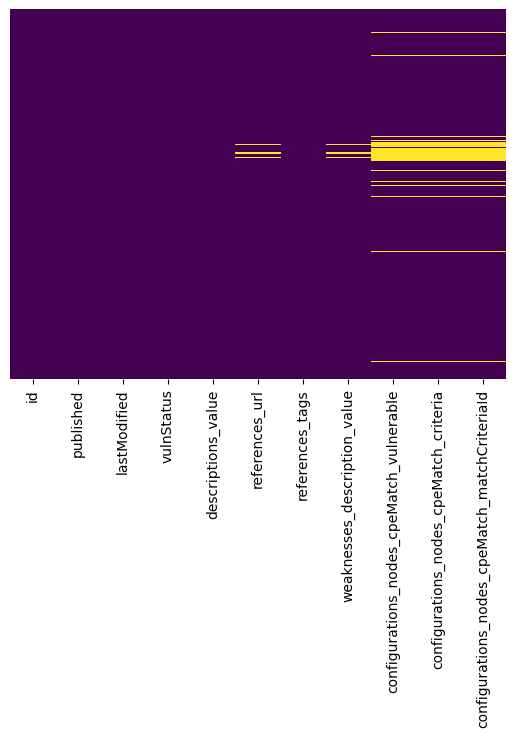

In [10]:
import seaborn as sns
sns.heatmap(df_cleaned.isnull(),yticklabels=False,cbar=False,cmap='viridis')


In [11]:
df['weaknesses_description_value'].unique()


array(['NVD-CWE-Other', nan, 'CWE-88', 'NVD-CWE-noinfo', 'CWE-78',
       'CWE-94', 'CWE-264', 'CWE-17', 'CWE-200', 'CWE-20', 'CWE-120',
       'CWE-119', 'CWE-255', 'CWE-178', 'CWE-307', 'CWE-59', 'CWE-327',
       'CWE-19', 'CWE-16', 'CWE-193', 'CWE-287', 'CWE-276', 'CWE-384',
       'CWE-362', 'CWE-346', 'CWE-665', 'CWE-772', 'CWE-79', 'CWE-254',
       'CWE-667', 'CWE-399'], dtype=object)

In [12]:
df_num = df

from sklearn.preprocessing import LabelEncoder
weakness_description_encoder = LabelEncoder()
df_num['weaknesses_description_value'] = weakness_description_encoder.fit_transform(df_num['weaknesses_description_value'])
df_num['published'] = df_num['published'].apply(lambda s: int(s[:4].ljust(4, '0')))
df_num['lastModified'] = df_num['lastModified'].apply(lambda s: int(s[:4].ljust(4, '0')))
df_num['configurations_nodes_cpeMatch_vulnerable'] = df_num['configurations_nodes_cpeMatch_vulnerable'].apply(lambda x: int(x) if not pd.isna(x) else x)
df_num = df_num.drop(columns = ['id', 'descriptions_value', 'references_url', 'configurations_nodes_cpeMatch_criteria','configurations_nodes_cpeMatch_matchCriteriaId', 'references_tags', 'weaknesses_description_value'])

strings_to_check = [item for sublist in df['references_tags'] for item in sublist]

for string in strings_to_check:
    df_num["referenceTag_" + string] = df['references_tags'].apply(lambda x: 1 if string in x else 0)
df_num

,published,lastModified,vulnStatus,configurations_nodes_cpeMatch_vulnerable,referenceTag_Patch,referenceTag_Third Party Advisory,referenceTag_US Government Resource,referenceTag_Vendor Advisory,referenceTag_Broken Link,referenceTag_VDB Entry,referenceTag_Exploit,referenceTag_URL Repurposed,referenceTag_Mailing List,referenceTag_Not Applicable
0,1988,2019,Modified,1.0,0,0,0,0,0,0,0,0,0,0
1,1988,2008,Analyzed,1.0,0,0,0,0,0,0,0,0,0,0
2,1989,2008,Analyzed,1.0,1,1,1,0,0,0,0,0,0,0
3,1989,2018,Modified,1.0,1,1,1,0,0,0,0,0,0,0
4,1989,2017,Modified,1.0,1,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,2000,2008,Analyzed,1.0,0,0,0,0,0,0,0,0,0,0
1996,2000,2008,Analyzed,1.0,0,0,0,0,0,0,0,0,0,0
1997,2000,2008,Analyzed,1.0,0,0,0,0,0,0,0,0,0,0
1998,2000,2008,Analyzed,1.0,0,0,0,0,0,0,0,0,0,0


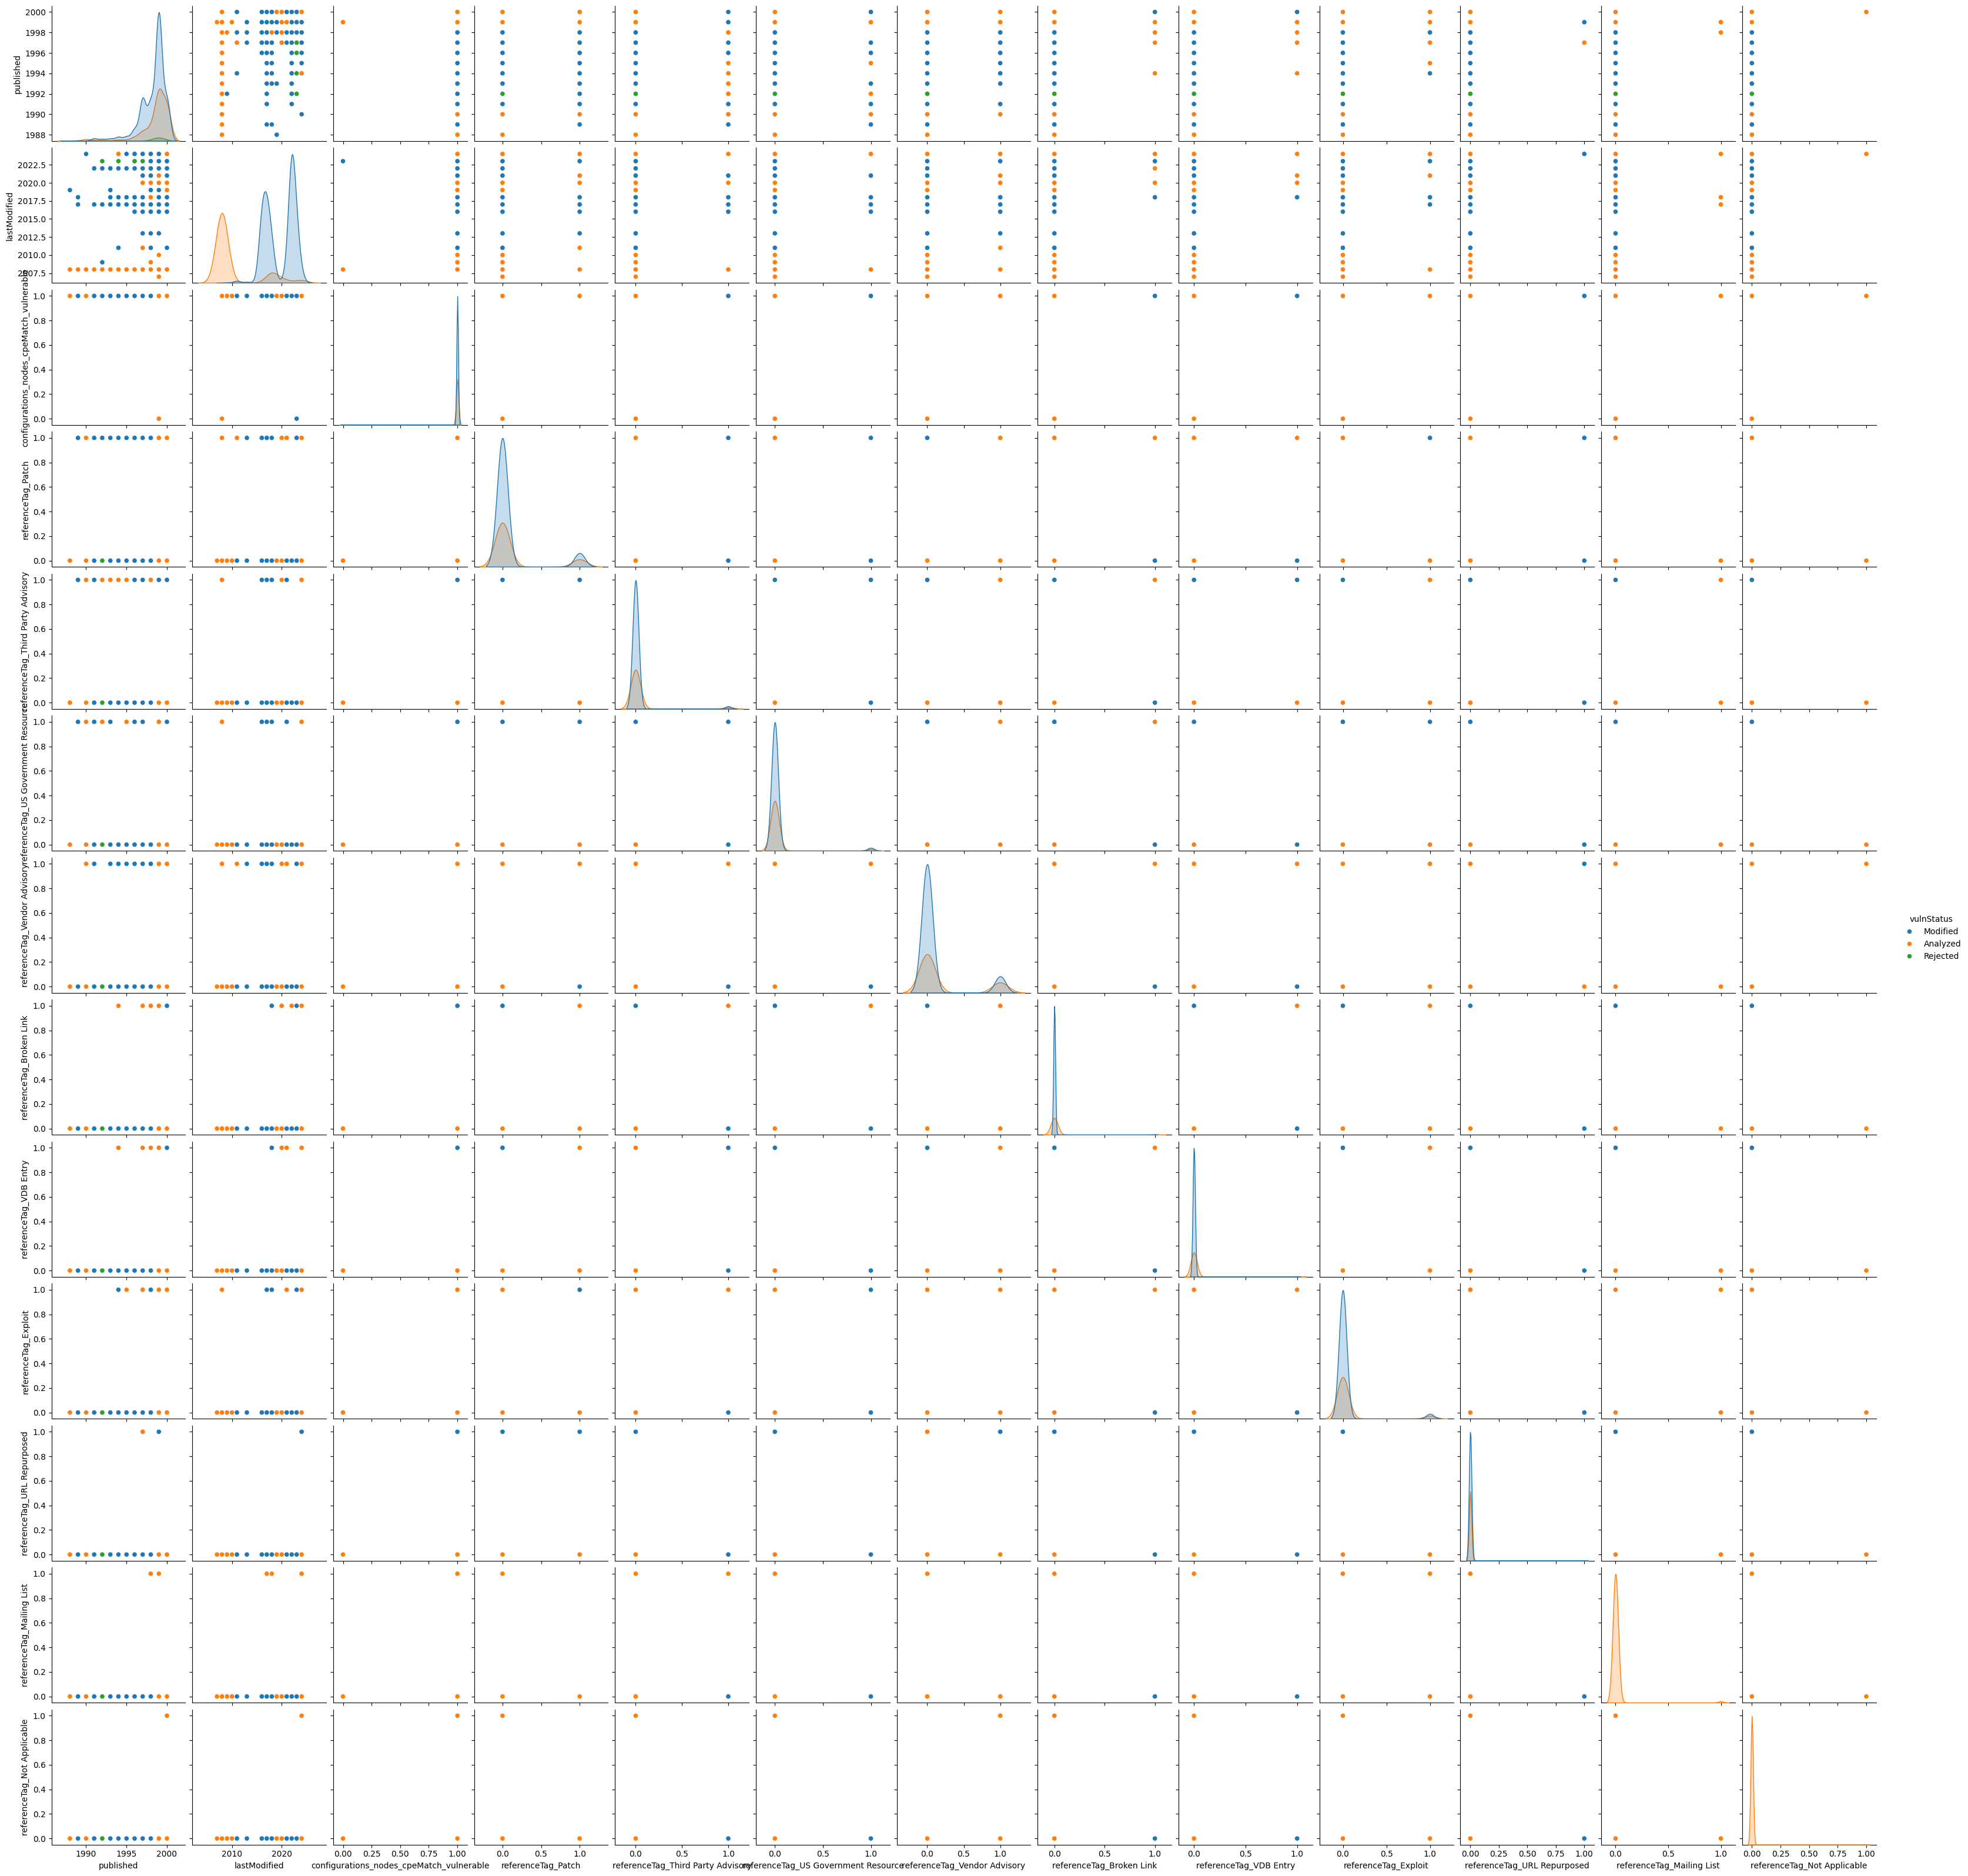

In [13]:
sns.pairplot(df_num, hue = 'vulnStatus')


<Axes: >

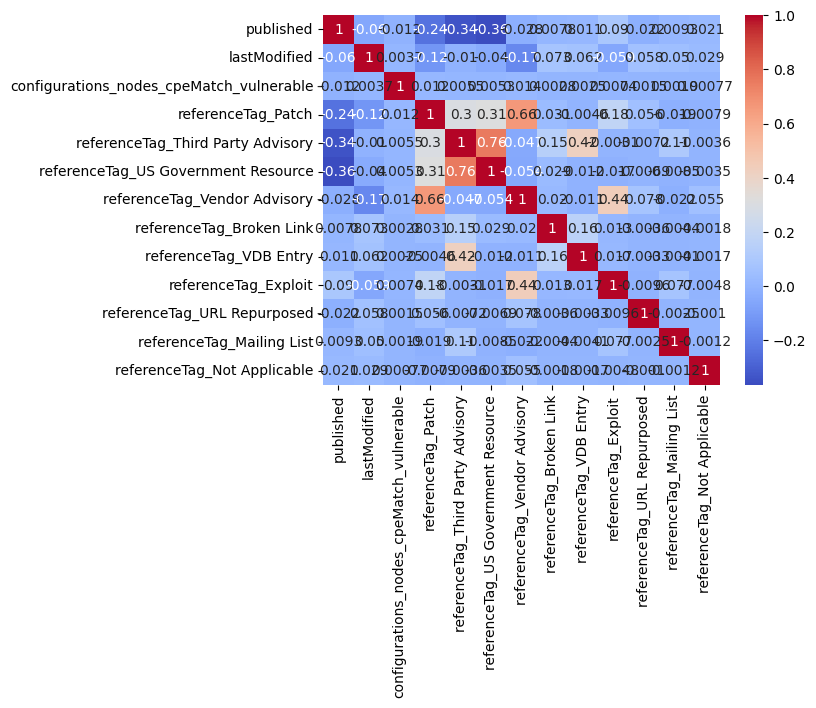

In [14]:
corr_matrix = df_num.drop(columns = "vulnStatus").corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')


In [15]:
df_num

,published,lastModified,vulnStatus,configurations_nodes_cpeMatch_vulnerable,referenceTag_Patch,referenceTag_Third Party Advisory,referenceTag_US Government Resource,referenceTag_Vendor Advisory,referenceTag_Broken Link,referenceTag_VDB Entry,referenceTag_Exploit,referenceTag_URL Repurposed,referenceTag_Mailing List,referenceTag_Not Applicable
0,1988,2019,Modified,1.0,0,0,0,0,0,0,0,0,0,0
1,1988,2008,Analyzed,1.0,0,0,0,0,0,0,0,0,0,0
2,1989,2008,Analyzed,1.0,1,1,1,0,0,0,0,0,0,0
3,1989,2018,Modified,1.0,1,1,1,0,0,0,0,0,0,0
4,1989,2017,Modified,1.0,1,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,2000,2008,Analyzed,1.0,0,0,0,0,0,0,0,0,0,0
1996,2000,2008,Analyzed,1.0,0,0,0,0,0,0,0,0,0,0
1997,2000,2008,Analyzed,1.0,0,0,0,0,0,0,0,0,0,0
1998,2000,2008,Analyzed,1.0,0,0,0,0,0,0,0,0,0,0


In [16]:
from sklearn.model_selection import train_test_split
df_num = df_num.dropna()
X = df_num.drop('vulnStatus',axis=1)
y = df_num['vulnStatus']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)


In [17]:
from sklearn.svm import SVC
svc_model = SVC()
svc_model.fit(X_train,y_train)
predictions = svc_model.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001]}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)
grid_predictions = grid.predict(X_test)
print(confusion_matrix(y_test,grid_predictions))
print(classification_report(y_test,grid_predictions))


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.0s
[CV] END ..................................C=0.1

In [18]:
#model predicts accurately with a 93% accuracy rate!
